# Cyclical features in time series forecasting

Cyclical features play an important role in time series prediction because they capture recurring patterns or oscillations within a data set. These patterns repeat at fixed intervals, and effective incorporation of cyclical features into a machine learning model requires careful pre-processing and feature engineering.

Due to the circular nature of cyclical features, it is not recommended to use them directly as numerical inputs in a machine learning model. Instead, they should be encoded in a format that captures their cyclical behaviour. There are several common encoding techniques:

+ One-hot encoding: If the cyclical feature consists of distinct categories, such as seasons or months, one-hot encoding can be used. This approach creates binary variables for each category, allowing the model to understand the presence or absence of specific categories.

+ Trigonometric coding: For periodic features such as time of day or day of week, trigonometric functions such as sine and cosine can be used for coding. By mapping the cyclic feature onto a unit circle, these functions preserve the cyclic relationships. In addition, this method introduces only two additional features, making it an efficient coding technique.

+ Basis functions: Basis functions are mathematical functions that span a vector space and can be used to represent other functions within that space. When using basis functions, the cyclic feature is transformed into a new set of features based on the chosen basis functions. Some commonly used basis functions for encoding cyclic features include Fourier basis functions, B-spline basis functions and Gaussian basis functions. B-Splines are a way to approximate non-linear functions by using a piece-wise combination of polynomials.

By applying these encoding techniques, cyclic features can be effectively incorporated into a machine learning model, allowing it to capture and exploit the valuable recurring patterns present in time series data.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">🖉 Note</b>
</p>

The following examples are is inspired by <a href="https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py">Time-related feature engineering</a>, <a href="https://scikit-lego.netlify.app/preprocessing.html#Repeating-Basis-Function-Transformer">scikit-lego’s documentation</a> and <a href="https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/">Three Approaches to Encoding Time Information as Features for ML Models By Eryk Lewinson</a>.
</div>
<br><br>

## Libraries

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import make_column_transformer
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

## Data

In [2]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)

# Data preparation
# ==============================================================================
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()

# Select only necessary columns
# ==============================================================================
data = data[['users', 'hour']]
data.head(3)

,users,hour
date_time,,
2011-01-01 00:00:00,16.0,0
2011-01-01 01:00:00,40.0,1
2011-01-01 02:00:00,32.0,2


In [3]:
# Split train-test
# ==============================================================================
data = data.loc['2012-03-01 00:00:00': '2012-06-30 23:00:00'].copy()
end_train = '2012-06-15 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(f"Dates train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train : 2012-03-01 00:00:00 --- 2012-06-15 23:00:00  (n=2568)
Dates test  : 2012-06-16 00:00:00 --- 2012-06-30 23:00:00  (n=360)


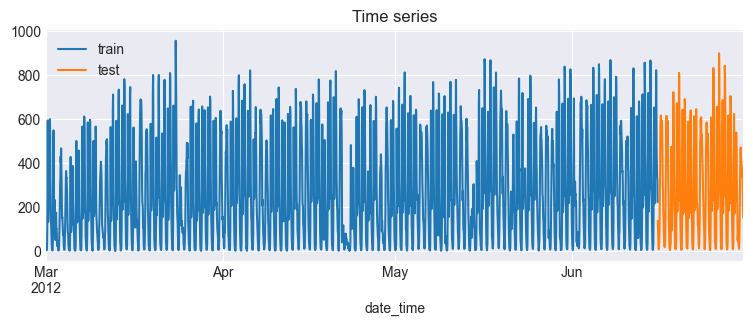

In [4]:
# Plot time series
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 3))
data_train['users'].plot(title="Time series", label="train", ax=ax)
data_test['users'].plot(title="Time series", label="test", ax=ax)
ax.legend();

## One hot encoding

In [5]:
# One hot encoding of week_day and hour_day
# ==============================================================================
one_hot_encoder = make_column_transformer(
                        (
                            OneHotEncoder(sparse_output=False, drop='if_binary'),
                            ['hour'],
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

data_encoded_oh = one_hot_encoder.fit_transform(data)
data_encoded_oh.head(3)

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,users
date_time,,,,,,,,,,,,,,,,,,,,,
2012-03-01 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
2012-03-01 01:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
2012-03-01 02:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


## Sine-Cosine encoding

In [6]:
# Cyclical encoding with sine/cosine transformation
# ==============================================================================
def sin_transformer(period):
	'''
	Returns a transformer that applies sine transformation to a variable using
	the specified period.
	'''
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	'''
	Returns a transformer that applies cosine transformation to a variable using
	the specified period.
	'''
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

data_encoded_sin_cos = data.copy()
data_encoded_sin_cos["hour_sin"] = sin_transformer(24).fit_transform(data_encoded_sin_cos['hour'])
data_encoded_sin_cos["hour_cos"] = cos_transformer(24).fit_transform(data_encoded_sin_cos['hour'])
data_encoded_sin_cos = data_encoded_sin_cos.drop(columns=['hour'])
data_encoded_sin_cos.head()

,users,hour_sin,hour_cos
date_time,,,
2012-03-01 00:00:00,11.0,0.000000,1.000000
2012-03-01 01:00:00,12.0,0.258819,0.965926
2012-03-01 02:00:00,6.0,0.500000,0.866025
2012-03-01 03:00:00,3.0,0.707107,0.707107
2012-03-01 04:00:00,5.0,0.866025,0.500000


## B-splines functions

In [18]:
# B-spline functions
# ==============================================================================
def spline_transformer(period, degree=3, extrapolation="periodic"):
    '''
    Returns a transformer that applies B-spline transformation.
    '''
    return SplineTransformer(
                degree=degree,
                n_knots=period + 1,
                knots='uniform',
                extrapolation=extrapolation,
                include_bias=True
            ).set_output(transform="pandas")

splines_hour = spline_transformer(period=24).fit_transform(data[['hour']])

The plot below depicts 24 radial basis functions generated using the hour number as input, with each curve representing the proximity to a specific hour of the day.

In [1]:
# Plot of the B-splines functions for the first 24 hours
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 6))
splines_hour.head(48).plot(
    ax       = ax,
    subplots = True,
    sharex   = True,
    legend   = False,
    yticks   = [],
    title    = 'Spline transformation of hour variable'
);

NameError: name 'plt' is not defined

In [20]:
data_encoded_splines = pd.concat([data, splines_hour], axis=1)
data_encoded_splines = data_encoded_splines.drop(columns=['hour'])
data_encoded_splines.head(3)

,users,hour_sp_0,hour_sp_1,hour_sp_2,hour_sp_3,hour_sp_4,hour_sp_5,hour_sp_6,hour_sp_7,hour_sp_8,...,hour_sp_14,hour_sp_15,hour_sp_16,hour_sp_17,hour_sp_18,hour_sp_19,hour_sp_20,hour_sp_21,hour_sp_22,hour_sp_23
date_time,,,,,,,,,,,,,,,,,,,,,
2012-03-01 00:00:00,11.0,0.166667,0.666667,0.166667,0.000000,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-01 01:00:00,12.0,0.000000,0.145859,0.664817,0.189310,0.000014,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-01 02:00:00,6.0,0.000000,0.000000,0.126860,0.659434,0.213597,0.00011,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Compare modeling results

A non-informative lag is included so that the impact of cyclical features can be assessed without being obscured by the lag.

In [21]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(),
                 lags = [5]
             )

In [22]:
# Train and validate a forecaster using each encoding method
# ==============================================================================

datasets = [data_encoded_oh, data_encoded_sin_cos, data_encoded_splines]
encoding_methods = ['one hot encoding', 'sine/cosine encoding', 'spline encoding']

for i, data_encoded in enumerate(datasets):

    metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data_encoded['users'],
                            exog               = data_encoded.drop(columns='users'),
                            initial_train_size = len(data_encoded.loc[:end_train]),
                            fixed_train_size   = False,
                            steps              = 90,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            verbose            = False, # Change to True to see detailed information,
                            show_progress      = False
                        )

    print(f"Backtest error using {encoding_methods[i]}: {metric:.2f}") 

Backtest error using one hot encoding: 18072.32
Backtest error using sine/cosine encoding: 15042.65
Backtest error using spline encoding: 16509.61


%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>